# Projet Stat - Exercice 1

## Description

Ce projet implémente un modèle d'arbre de décision pour la régression, avec validation croisée pour évaluer les performances du modèle. Le but du projet était de refaire à la main cet implémentation, voici le rapport et le détail de cette exercice.

## Implémentation

J'ai d'abord commencé par faire mes normes qui serviront plus tard pour la décission des coupures des noeuds.
Pour cela j'ai fait 2 fonctions : 
- la première la norme q-ième, qui prend en paramètre un vecteur et un entier q et qui retourne la norme q-ième de ce vecteur.
- la deuxième est la variance pondérée, qui prend en paramètre un vecteur et fait la variance de ce vecteur et le mutliplie par la taille du vecteur.

J'ai fait ces 2 fonctions car après plusieurs test la norme q-ième n'apas donné de bons résultats, donc j'ai décidé de faire une moyenne pondérée qui c'est avéré plus efficace.


In [1]:
import pandas as pd
import numpy as np
from graphviz import Digraph
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt

In [2]:
def normQ(x,q):
    """
    :param x: donnée
    :param q: q-ième Norme
    :return: Norme q-ième de x
    """
    return np.sum(np.abs(x)**q)**(1/q)

def variance_pond(x):
    """
    Variance pondérée
    :param x: donnée
    :return: variance pondérée
    """
    return np.var(x) * len(x)

Ensuite pour commencer l'implémentation des arbres j'ai commencé par faire une classe `Noeud` assez ckassique avec les attributs suivants :
- `gauche` : le fils gauche du noeud
- `droite` : le fils droit du noeud
- `colonne` : la colonne sur laquelle on a fait la coupure
- `seuil` : le seuil de la coupure
- `individus` : les individus du noeud
- `moyenne` : la moyenne des individus du noeud

In [3]:
class Noeud:
    def __init__(self, seuil = None, colonne = None, gauche = None, droite = None, individus=None, moyenne=None):
        """
        Constructeur d'un objet nœud
        :param seuil: seuil de la coupure
        :param colonne: colonne concerné
        :param gauche: nœud à sa gauche
        :param droite: nœud à sa droite
        :param individus: liste des individus du nœud
        :param moyenne: moyenne des individus
        """
        if individus is None:
            individus = []
        self.colonne = colonne
        self.seuil = seuil
        self.gauche = gauche
        self.droite = droite
        self.individus = individus
        self.moyenne = moyenne

    def est_feuille(self):
        """
        Vérifie si le nœud est une feuille ou non
        :return: bool
        """
        return self.gauche is None and self.droite is None

    def nbr_individus(self):
        """
        :return: Nombre d'individus dans le nœud
        """
        return len(self.individus)

    def __repr__(self, profondeur=0):
        if self.est_feuille():
            return f"{self.moyenne},{profondeur}"
        else:
            return f"Colonne : {self.colonne}\nSeuil : {self.seuil}\n" \
                   f"Gauche : {self.gauche.__repr__(profondeur+1)}\n" \
                   f"Droite : {self.droite.__repr__(profondeur+1)}"

On va pouvoir maintenant passer à l'arbre de décision, pour cela j'ai fait une classe `Arbre` avec les attributs suivants :
- `data` : data frame avec les features X
- `cible` : data frame avec la cible Y
- `profondeur_max` : la profondeur maximum de l'arbre (pour la construction)
- `verbose` : pour afficher les logs
- `seuil_variance` : seuil de variance pour arrêter la construction de l'arbre
- `racine` : le noeud racine de l'arbre
- `predictions_test` : les prédictions sur le test

Fontions de la classe `Arbre` :
- `sepraration` : Recherche de la meilleure séparation des données
- `fit` : Création de l'arbre complet avec les meilleures coupures
- `simulation` : Simulation de nouveaux individus
- `_simulation_indivudus` : Sous fonction pour la simulation
- `visualiser_arbre` : Visualisation de l'arbre avec la bibliothèque graphviz (nécessite l'intallation de graphviz sur votre machine)
- `_ajouter_noeud` : Sous fonction pour ajouter un noeud à l'arbre pour la visualisation

In [4]:
class Arbre:
    def __init__(self, data, cible, profondeur_max=3, verbose=False,seuil_variance=1.5):
        """
        Constructeur d'un objet Arbre
        :param data: dataframe avec les features X
        :param cible: tableau avec les valeurs cible Y
        :param profondeur_max: profondeur max de l'arbre
        :param verbose: sortie écrite lors des fonctions
        :param seuil_variance: cas d'arrêt variance au sein d'un nœud de l'arbre
        """
        self.data = data
        self.cible = cible
        self.profondeur_max = profondeur_max
        self.verbose = verbose
        self.seuil_variance = seuil_variance
        self.racine = self.fit(data, cible, profondeur=0)  # Premier appel de fit avec profondeur=0
        self.predictions_test = self.simulation(self.data)
        self.score_test(self.predictions_test)


    def score_test(self,predictions_test):
        """
        Calcul l'erreur moyenne quadratique de l'arbre
        :param predictions_test: prediction sur l'ensemble d'entrainement
        :return: 0
        """
        if self.verbose:
            print("Valeur test de l'arbre : "+str(np.mean((self.cible - predictions_test) ** 2)))

    def separation(self, data):
        """
        Recherche de la meilleure séparation des données
        :param data: donnée X et Y
        :param verbose: affichage ou non
        :return: meilleur_seuil, meilleur_colonne
        """
        meilleur_cout = float('inf')
        meilleur_seuil = None
        meilleur_col = None

        for col in self.data.columns:
            val = data[col].sort_values().unique()  # Trier les valeurs de la colonne
            alphas = [(val[i] + val[i+1]) / 2 for i in range(len(val)-1)]  # Alphas

            for alpha in alphas:
                gauche = data[data[col] <= alpha]
                droite = data[data[col] > alpha]

                # récupérer les cibles
                cibles_gauche = self.cible[gauche.index]
                cibles_droite = self.cible[droite.index]

                # Calculer le coût : ici, on utilise la variance pondérée comme exemple
                cout_gauche = variance_pond(cibles_gauche)
                cout_droite = variance_pond(cibles_droite)
                cout_total = cout_gauche + cout_droite  # Coût total pour cette coupure
                if cout_total < meilleur_cout:  # Vérifier si c'est la meilleure coupure
                    meilleur_cout = cout_total
                    meilleur_seuil = alpha
                    meilleur_col = col

        if self.verbose:
            # Affichage conditionnel si une coupure a été trouvée
            if meilleur_seuil is not None and meilleur_col is not None:
                print(f"Meilleur coût : {meilleur_cout:.2f}, Colonne : {meilleur_col}, Seuil : {meilleur_seuil:.2f}")
            else:
                print("Aucune coupure valide trouvée")
        return meilleur_seuil, meilleur_col

    def fit(self, data, cible, profondeur=0, seuil_variance = None):
        """
        Création de l'arbre complet avec les meilleures coupures
        :param data: valeur de X
        :param cible: valeur de Y
        :param seuil_variance: seuille de variance
        :param profondeur: profondeur actuel
        :return: arbre
        """
        if seuil_variance is None:
            seuil_variance = self.seuil_variance
        # condition d'arrêt
        if profondeur >= self.profondeur_max:
            if self.verbose:
                print("noeud terminal Arrêt à la profondeur max", profondeur)
            return Noeud(individus=cible, moyenne=np.mean(cible))

        if np.var(cible) < seuil_variance:
            if self.verbose:
                print("nombre d'individu",len(cible))
                print("noeud terminal Arrêt à la profondeur à cause du seuil de variance", profondeur, np.var(cible))
            return Noeud(individus=cible, moyenne=np.mean(cible))
        # recherche de la meilleure coupure
        seuil, colonne = self.separation(data)

        if seuil is None:
            if self.verbose:
                print("noeud terminal Aucune coupure trouvée à la profondeur", profondeur)
            return Noeud(individus=cible, moyenne=np.mean(cible))

        # séparation des données
        gauche = data[data[colonne] <= seuil]
        cibles_gauche = cible[gauche.index]

        droite = data[data[colonne] > seuil]
        cibles_droite = cible[droite.index]

        # Créer les sous-arbres récursivement
        noeud_gauche = self.fit(gauche, cibles_gauche, profondeur=profondeur + 1)  # Incrémenter la profondeur
        noeud_droite = self.fit(droite, cibles_droite, profondeur=profondeur + 1)  # Incrémenter la profondeur

        # Retourner le nœud avec la condition de coupure et les sous-arbres gauche et droite
        return Noeud(seuil=seuil, colonne=colonne,
                     gauche=noeud_gauche, droite=noeud_droite, individus=cible, moyenne=np.mean(cible))

    def simulation(self, nouvelle_donnee):
        """
        Simulation de nouveaux individus
        :param nouvelle_donnee: matrice d'individus
        :return: tableau des predictions
        """
        predictions = []
        for _,ligne in nouvelle_donnee.iterrows():
            predictions.append(self._simulation_individu(self.racine, ligne))
        return predictions

    def _simulation_individu(self, noeud, individu):
        if noeud.est_feuille():
            return noeud.moyenne

        if individu[noeud.colonne] <= noeud.seuil:
            return self._simulation_individu(noeud.gauche, individu)
        else:
            return self._simulation_individu(noeud.droite, individu)

    def visualiser_arbre(self):
        """
        Enregistre l'arbre de décision au format png
        """
        # Créer un objet Digraph pour l'arbre
        graph = Digraph()
        self._ajouter_noeud(self.racine, graph)
        graph.render("arbre_decision", format="png", cleanup=True)  # Sauvegarde en PNG
        print("Arbre de décision sauvegardé sous 'arbre_decission.png'")

    def _ajouter_noeud(self, noeud, graph, parent_id=None, direction=None, profondeur=0):
        # Générer un identifiant unique pour chaque nœud
        node_id = str(id(noeud))

        # Déterminer l'étiquette du nœud
        if noeud.est_feuille():
            label = f"Moyenne : {noeud.moyenne:.2f}\nProfondeur : {profondeur} nombre individu : {noeud.nbr_individus()}"
        else:
            label = f"{noeud.colonne} <= {noeud.seuil:.2f}\nProfondeur : {profondeur}"

        # Ajouter le nœud au graphique
        graph.node(node_id, label=label)

        # Ajouter une arête depuis le parent si ce n'est pas la racine
        if parent_id is not None:
            graph.edge(parent_id, node_id, label=direction)

        # Appeler récursivement pour les sous-arbres gauche et droit
        if noeud.gauche:
            self._ajouter_noeud(noeud.gauche, graph, node_id, "Oui", profondeur + 1)
        if noeud.droite:
            self._ajouter_noeud(noeud.droite, graph, node_id, "Non", profondeur + 1)

    def __repr__(self):
        return self.racine.__repr__()

## Utilisation

J'ai pris la décission de donner directement les données dans le constructeur de la classe `Arbre` et de faire directement un fit à l'appel de la classe et de simuler aussi directement les données d'entrainement pour avoir le score de test.

Voici un premier exemple d'utilisation :

In [5]:
r = 500  # Nombre d'échantillons (lignes dans X)
p = 5  # Nombre de caractéristiques (colonnes dans X)
s = 2  # Nombre de caractéristiques non-nulles dans chaque theta
sigma = 0.5  # Écart-type du bruit gaussien

# Générer la matrice X avec des valeurs de Rademacher (1 ou -1 avec probabilité 1/2)
X = np.random.choice([-1, 1], size=(r, p))

# Générer theta et Y
theta_list = []
Y = np.zeros(r)

for j in range(r):
    # Générer theta^j avec exactement s valeurs non-nulles choisies aléatoirement parmi p
    theta = np.zeros(p)
    indices = np.random.choice(p, s, replace=False)  # Choisir s indices aléatoires
    theta[indices] = 1
    theta_list.append(theta)
    # Calculer Y^j = <X^j, theta^j> + epsilon
    epsilon = np.random.normal(0, sigma)
    Y[j] = X[j] @ theta + epsilon

# Conversion en DataFrame pour utiliser avec l'arbre
data = pd.DataFrame(X, columns=[f'X{i}' for i in range(p)])
cible = pd.Series(Y, name="target")

print("Données d'entrée (X):")
print(data.head())
print("\nValeurs cibles (Y):")
print(cible.head())

# couper les données pour avoir test et train
X_train, X_test, y_train, y_test = train_test_split(data, cible, test_size=0.3, random_state=42)

profondeur_max = 7
# Instancier et entraîner l'arbre
arbre = Arbre(X_train, y_train, profondeur_max=profondeur_max)
# Visualisation de l'arbre
arbre.visualiser_arbre()

Données d'entrée (X):
   X0  X1  X2  X3  X4
0   1  -1   1  -1   1
1   1   1  -1   1   1
2   1   1  -1  -1   1
3  -1   1   1   1   1
4  -1  -1   1  -1  -1

Valeurs cibles (Y):
0    0.270287
1    0.975138
2   -0.028644
3    1.830122
4   -2.227994
Name: target, dtype: float64
Arbre de décision sauvegardé sous 'arbre_decission.png'


## Implémentation de la validation croisé

Pour l'implémentation de la validation croisé j'ai décidé de faire uen fonction `validation_croisee` qui utilise KFlod de sklearn pour facilité la séparation des données et la validation croisé, mais le reste est fait à la main.

paramètres de la fonction :
- `data` : data frame avec les features X
- `cible` : data frame avec les cible Y
- `profondeur_max` : la profondeur maximum de l'arbre (pour la construction)
- `n_splits` : le nombre de split pour la validation croisé

In [11]:
def validation_croisee(data, cible, profondeur_max, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    erreurs_moyennes = []
    modeles = []  # Liste pour stocker tous les modèles
    
    # Boucle sur chaque pli
    for train_index, test_index in kf.split(data):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = cible.iloc[train_index], cible.iloc[test_index]
        
        arbre = Arbre(X_train, y_train, profondeur_max=profondeur_max)
        predictions_test = arbre.simulation(X_test)
        erreur = mean_squared_error(y_test, predictions_test)
        erreurs_moyennes.append(erreur)
        modeles.append(arbre)  # Sauvegarder le modèle
        print(f"Erreur quadratique moyenne pour ce pli : {erreur:.4f}")
    
    erreur_moyenne = np.mean(erreurs_moyennes)
    print(f"\nErreur quadratique moyenne sur les {n_splits} plis : {erreur_moyenne:.4f}")
    return erreur_moyenne, modeles  # Retourner tous les modèles

Exemple d'utilisation :


Profondeur max : 5
Erreur quadratique moyenne pour ce pli : 1.7729
Erreur quadratique moyenne pour ce pli : 2.0672
Erreur quadratique moyenne pour ce pli : 1.6154
Erreur quadratique moyenne pour ce pli : 1.6780
Erreur quadratique moyenne pour ce pli : 1.6192

Erreur quadratique moyenne sur les 5 plis : 1.7505

Profondeur max : 6
Erreur quadratique moyenne pour ce pli : 1.7729
Erreur quadratique moyenne pour ce pli : 2.0672
Erreur quadratique moyenne pour ce pli : 1.6154
Erreur quadratique moyenne pour ce pli : 1.6780
Erreur quadratique moyenne pour ce pli : 1.6192

Erreur quadratique moyenne sur les 5 plis : 1.7505

Profondeur max : 7
Erreur quadratique moyenne pour ce pli : 1.7729
Erreur quadratique moyenne pour ce pli : 2.0672
Erreur quadratique moyenne pour ce pli : 1.6154
Erreur quadratique moyenne pour ce pli : 1.6780
Erreur quadratique moyenne pour ce pli : 1.6192

Erreur quadratique moyenne sur les 5 plis : 1.7505


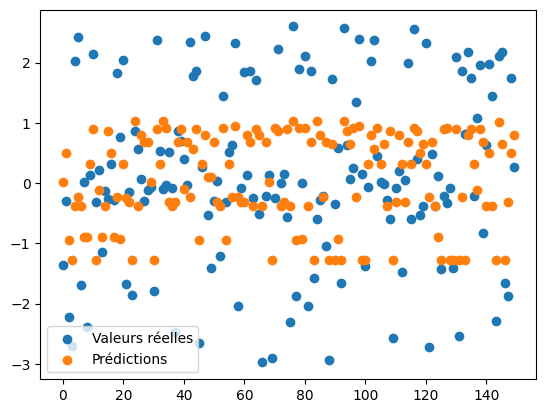

Meilleure profondeur : 5
Erreur quadratique moyenne finale :  1.4343542473247002


In [17]:
# Liste des profondeurs à tester
profondeurs_possibles = [5, 6, 7]  # On ajoute cette ligne !

# Validation croisée
meilleurs_modeles = None
meilleure_erreur = float('inf')
meilleure_profondeur = None

for profondeur in profondeurs_possibles:
    print(f"\nProfondeur max : {profondeur}")
    erreur_moyenne, modeles = validation_croisee(data, cible, profondeur_max=profondeur, n_splits=5)
    if erreur_moyenne < meilleure_erreur:
        meilleure_erreur = erreur_moyenne
        meilleurs_modeles = modeles
        meilleure_profondeur = profondeur

# Prédiction finale avec les meilleurs modèles
predictions_finales = np.zeros(len(X_test))
for arbre in meilleurs_modeles:
    predictions = arbre.simulation(X_test)
    predictions_finales += predictions
predictions_finales /= len(meilleurs_modeles)

# Graphique et erreur finale
plt.scatter(X, y_test, label='Valeurs réelles')
plt.scatter(X, predictions_finales, label='Prédictions')
plt.legend()
plt.show()

print(f"Meilleure profondeur : {meilleure_profondeur}")
print("Erreur quadratique moyenne finale : ", mean_squared_error(y_test, predictions_finales))

## Implémentation du gradient boosting

Pour l'implémentation du gradient boosting j'ai décidé de faire une classe `gradient_boosting` avec les attributs suivants :
- `n_estimators` : le nombre d'arbres
- `learning_rate` : le taux d'apprentissage
- `profondeur_max` : la profondeur maximum de l'arbre (pour la construction)
- `seuil_variance` : seuil de variance pour arrêter la construction de l'arbre
- `verbose` : pour afficher les logs

Fonctions de la classe `gradient_boosting` :
- `fit` : Création de l'arbre complet avec les meilleures coupures
- `predict` : Prédiction sur de nouvelles données
- `tracer_erreurs` : Trace l'évolution des erreurs d'entraînement et de validation.

In [8]:
class GradientBoosting:
    def __init__(self, n_estimators=10, learning_rate=0.1, profondeur_max=3, seuil_variance=1.5, verbose=False):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.profondeur_max = profondeur_max
        self.seuil_variance = seuil_variance
        self.verbose = verbose
        self.arbres = []  # Liste des arbres entraînés
        self.erreurs_entrainement = []  # Suivi des erreurs d'entraînement
        self.erreurs_validation = []  # Suivi des erreurs de validation

    def fit(self, data, cible, data_val=None, cible_val=None):
        """
        Entraîne les arbres séquentiellement.
        :param data: Données d'entraînement (features).
        :param cible: Valeurs cibles (target).
        :param data_val: Données de validation (features).
        :param cible_val: Valeurs cibles de validation (target).
        """
        residus = cible.copy()  # Initialiser les résidus avec la cible
        for i in range(self.n_estimators):
            if self.verbose:
                print(f"\nEntraînement de l'arbre {i+1}/{self.n_estimators}")

            # Entraîner un arbre sur les résidus
            arbre = Arbre(data, residus, profondeur_max=self.profondeur_max, verbose=False, seuil_variance=self.seuil_variance)
            self.arbres.append(arbre)

            # Prédire avec l'arbre actuel
            predictions_train = self.predict(data, jusqu_a=i+1)

            # Calcul de l'erreur d'entraînement
            erreur_entrainement = mean_squared_error(cible, predictions_train)
            self.erreurs_entrainement.append(erreur_entrainement)

            # Si des données de validation sont fournies, calculer l'erreur de validation
            if data_val is not None and cible_val is not None:
                predictions_val = self.predict(data_val, jusqu_a=i+1)
                erreur_validation = mean_squared_error(cible_val, predictions_val)
                self.erreurs_validation.append(erreur_validation)

            # Mettre à jour les résidus
            predictions = arbre.simulation(data)
            residus -= self.learning_rate * np.array(predictions)

            if self.verbose:
                print(f"Erreur d'entraînement après l'arbre {i+1} : {erreur_entrainement:.4f}")
                if data_val is not None:
                    print(f"Erreur de validation après l'arbre {i+1} : {erreur_validation:.4f}")

    def predict(self, data, jusqu_a=None):
        """
        Effectue des prédictions avec tous les arbres ou jusqu'à un certain arbre.
        :param data: Données d'entrée (features).
        :param jusqu_a: Nombre d'arbres à utiliser pour la prédiction (None pour tous les arbres).
        :return: Prédictions globales.
        """
        if jusqu_a is None:
            jusqu_a = len(self.arbres)

        predictions = np.zeros(len(data))  # Initialiser avec zéro
        for i in range(jusqu_a):
            predictions += self.learning_rate * np.array(self.arbres[i].simulation(data))
        return predictions

    def tracer_erreurs(self):
        """
        Trace l'évolution des erreurs d'entraînement et de validation.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.erreurs_entrainement, label='Erreur d\'entraînement', marker='o')
        if self.erreurs_validation:
            plt.plot(self.erreurs_validation, label='Erreur de validation', marker='o')
        plt.title('Évolution des erreurs au fil des arbres')
        plt.xlabel('Nombre d\'arbres')
        plt.ylabel('Erreur quadratique moyenne')
        plt.legend()
        plt.grid(True)
        plt.show()

Exemple d'utilisation :


Entraînement de l'arbre 1/50
Erreur d'entraînement après l'arbre 1 : 2.0407
Erreur de validation après l'arbre 1 : 2.0135

Entraînement de l'arbre 2/50
Erreur d'entraînement après l'arbre 2 : 1.9130
Erreur de validation après l'arbre 2 : 1.9408

Entraînement de l'arbre 3/50
Erreur d'entraînement après l'arbre 3 : 1.8095
Erreur de validation après l'arbre 3 : 1.8842

Entraînement de l'arbre 4/50
Erreur d'entraînement après l'arbre 4 : 1.7257
Erreur de validation après l'arbre 4 : 1.8404

Entraînement de l'arbre 5/50
Erreur d'entraînement après l'arbre 5 : 1.6578
Erreur de validation après l'arbre 5 : 1.8067

Entraînement de l'arbre 6/50
Erreur d'entraînement après l'arbre 6 : 1.6029
Erreur de validation après l'arbre 6 : 1.7810

Entraînement de l'arbre 7/50
Erreur d'entraînement après l'arbre 7 : 1.5583
Erreur de validation après l'arbre 7 : 1.7617

Entraînement de l'arbre 8/50
Erreur d'entraînement après l'arbre 8 : 1.5223
Erreur de validation après l'arbre 8 : 1.7474

Entraînement de

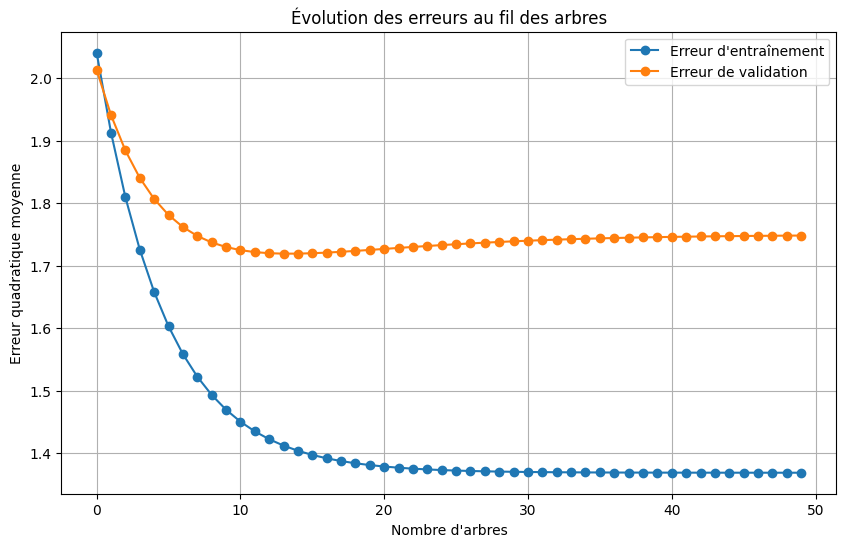

In [10]:
# Entraîner le modèle de Gradient Boosting
data_train, data_val, cible_train, cible_val = train_test_split(data, cible, test_size=0.2, random_state=42)
gb = GradientBoosting(n_estimators=50, learning_rate=0.1, profondeur_max=8, verbose=True, seuil_variance=0.5)
gb.fit(data_train, cible_train, data_val=data_val, cible_val=cible_val)

# Tracer l'évolution des erreurs
gb.tracer_erreurs()